In [55]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from geopy.distance import geodesic
from haversine import haversine, Unit

In [56]:
bike_data = pd.read_csv('data/202401-citibike-tripdata.csv')

/var/folders/8c/3n532t214sl7q0wy9wf_qks00000gn/T/ipykernel_1222/3675483451.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  bike_data = pd.read_csv('data/202401-citibike-tripdata.csv')


In [57]:
bike_data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,5078F3D302000BD2,electric_bike,2024-01-22 18:43:19.012,2024-01-22 18:48:10.708,Frederick Douglass Blvd & W 145 St,7954.12,St Nicholas Ave & W 126 St,7756.10,40.823072,-73.941738,40.811432,-73.951878,member
1,814337105D37302A,electric_bike,2024-01-11 19:19:18.721,2024-01-11 19:47:36.007,W 54 St & 6 Ave,6771.13,E 74 St & 1 Ave,6953.08,40.761822,-73.977036,40.768974,-73.954823,member
2,A33A920E2B10710C,electric_bike,2024-01-30 19:17:41.693,2024-01-30 19:32:49.857,E 11 St & Ave B,5659.11,W 10 St & Washington St,5847.06,40.727592,-73.979751,40.733424,-74.008515,casual
3,A3A5FC0DD7D34D74,electric_bike,2024-01-27 11:27:01.759,2024-01-27 11:38:01.213,W 54 St & 6 Ave,6771.13,E 74 St & 1 Ave,6953.08,40.761779,-73.977144,40.768974,-73.954823,member
4,6F96728ECEFBDAA4,electric_bike,2024-01-16 15:15:41.000,2024-01-16 15:29:26.156,Madison Ave & E 99 St,7443.01,E 74 St & 1 Ave,6953.08,40.789808,-73.952214,40.768974,-73.954823,member


In [58]:
bike_data.shape

(1888085, 13)

In [59]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888085 entries, 0 to 1888084
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 187.3+ MB


In [60]:
bike_data.describe()

,start_lat,start_lng,end_lat,end_lng
count,1.888085e+06,1.888085e+06,1.887534e+06,1.887534e+06
mean,4.073898e+01,-7.397188e+01,4.073888e+01,-7.397208e+01
std,4.003527e-02,2.818343e-02,3.990145e-02,2.816227e-02
min,4.056315e+01,-7.402699e+01,4.058000e+01,-7.406692e+01
25%,4.071495e+01,-7.399164e+01,4.071503e+01,-7.399177e+01
50%,4.073932e+01,-7.397964e+01,4.073913e+01,-7.397974e+01
75%,4.076193e+01,-7.395587e+01,4.076171e+01,-7.395596e+01
max,4.088636e+01,-7.384962e+01,4.092000e+01,-7.379000e+01


# Feature Engineering

In [61]:
# Check for NaN values in latitude and longitude columns
print(bike_data[['start_lat', 'start_lng', 'end_lat', 'end_lng']].isnull().sum())


start_lat      0
start_lng      0
end_lat      551
end_lng      551
dtype: int64


In [62]:
# Drop rows with NaN values in latitude and longitude columns
bike_data = bike_data.dropna(subset=['end_lat', 'end_lng'])

## Calculate Duration (in minutes) and create duration types (short, average, long, extra long)

In [63]:
bike_data['started_at'] = pd.to_datetime(bike_data['started_at'])
bike_data['ended_at'] = pd.to_datetime(bike_data['ended_at'])
bike_data['duration'] = (bike_data['ended_at'] - bike_data['started_at']).dt.total_seconds() / 60  # convert to minutes


In [64]:
bike_data['duration'] = np.where(bike_data['duration'] < 60, "short_trip", np.where(
    (bike_data['duration'] > 60) & (bike_data['duration'] < 60 * 24), "average_trip", np.where(
    (bike_data['duration'] > 60 * 24) & (bike_data['duration'] < 60 * 24 * 30), "long_trip",
        "extra_long_trip")))

## Calculate Distance (in kilometers) 

In [65]:
def calculate_distances_vectorized(df):
    start_coords = list(zip(df['start_lat'], df['start_lng']))
    end_coords = list(zip(df['end_lat'], df['end_lng']))
    return np.array([haversine(start, end, unit=Unit.KILOMETERS) for start, end in zip(start_coords, end_coords)])


In [66]:
bike_data['distance'] = calculate_distances_vectorized(bike_data)

## Encode the 'member_casual', 'rideable_type', 'duration' column

In [68]:
label_encoder = LabelEncoder()
bike_data['member_casual_encoded'] = label_encoder.fit_transform(bike_data['member_casual'])
bike_data['rideable_type_encoded'] = label_encoder.fit_transform(bike_data['rideable_type'])
bike_data['duration_type_encoded'] = label_encoder.fit_transform(bike_data['duration'])

## Select relevant features

In [102]:
# Select relevant features for anomaly detection
# features = ['duration', 'distance', 'member_casual_encoded']
# features = ['duration_type_encoded', 'distance', 'member_casual_encoded', 'rideable_type_encoded']
features = ['duration_type_encoded']
X = bike_data[features]


# Data Analysis

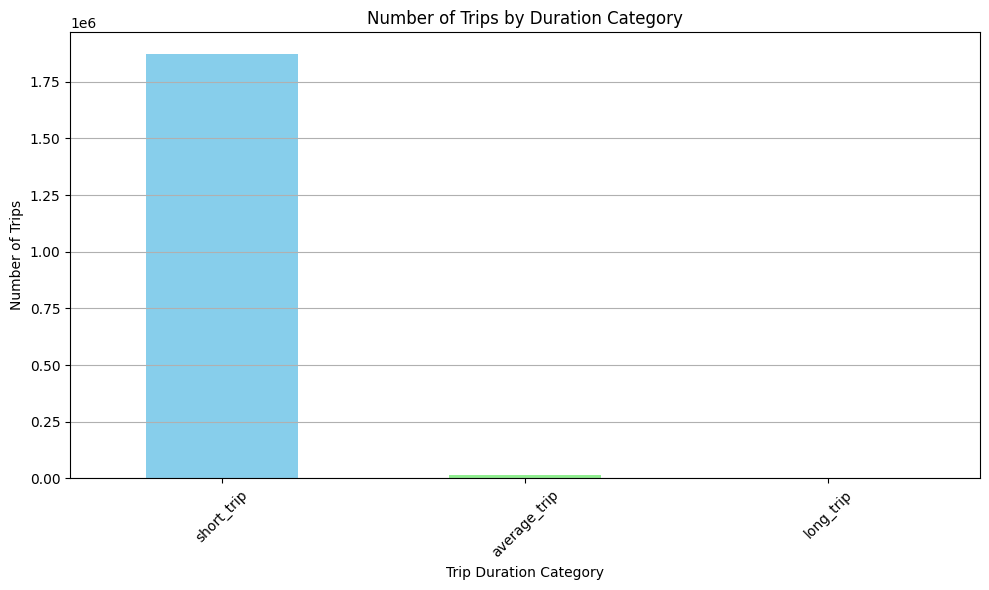

In [107]:
# Count the number of trips in each category
trip_counts = bike_data['duration'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
trip_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.title('Number of Trips by Duration Category')
plt.xlabel('Trip Duration Category')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

In [108]:
trip_counts

duration
short_trip      1873889
average_trip      13589
long_trip            56
Name: count, dtype: int64

In [109]:
contamination = trip_counts['long_trip'] / bike_data.shape[0]

In [112]:
contamination

np.float64(2.9668339749111804e-05)

# Train Isolation Forest

In [121]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=contamination, n_estimators=100, max_samples=0.6, max_features=0.9) 

# Fit the model to the data
bike_data['anomaly'] = iso_forest.fit_predict(X)


# Plot the Anomalies

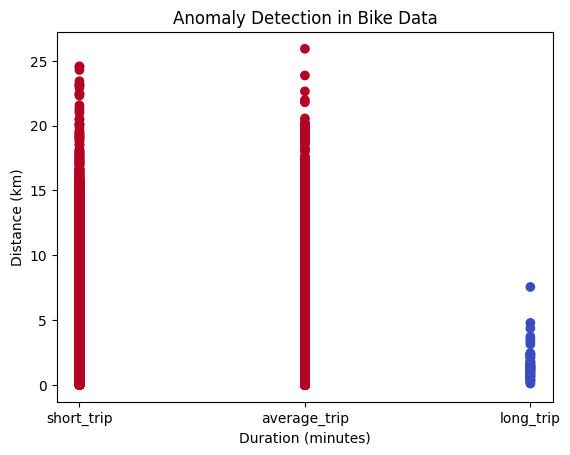

                ride_id  rideable_type              started_at  \
307    904475C6D11A9D5D   classic_bike 2024-01-19 22:16:56.216   
480    23B12F2A3BF35940   classic_bike 2024-01-27 12:48:55.980   
16580  184C364C8536B4AB   classic_bike 2024-01-10 07:05:37.065   
16582  4880E18EEB04E9CC  electric_bike 2024-01-07 07:39:08.467   
16677  AE2F7F32EE59295A   classic_bike 2024-01-05 17:12:27.542   

                     ended_at         start_station_name start_station_id  \
307   2024-01-20 23:16:50.855    Wyckoff Ave & Gates Ave          4847.03   
480   2024-01-28 13:49:25.511  Bushwick Ave & Forrest St          4914.03   
16580 2024-01-11 08:05:30.540            E 31 St & 3 Ave          6239.08   
16582 2024-01-08 08:38:52.187   Bushwick Ave & Powers St          5250.05   
16677 2024-01-06 18:12:05.109  Clay Ave & Claremont Pkwy          8225.05   

      end_station_name end_station_id  start_lat  start_lng  end_lat  end_lng  \
307                NaN            NaN  40.699871 -73.911719

In [122]:
# Visualize the anomalies (1 = normal, -1 = anomaly)
plt.scatter(bike_data['duration'], bike_data['distance'], c=bike_data['anomaly'], cmap='coolwarm')
plt.xlabel('Duration (minutes)')
plt.ylabel('Distance (km)')
plt.title('Anomaly Detection in Bike Data')
plt.show()

# Print detected anomalies
anomalies = bike_data[bike_data['anomaly'] == -1]
print(anomalies.head())

In [118]:
anomalies.shape

(56, 19)

In [81]:
# Separate data by member type
members = bike_data[bike_data['member_casual_encoded'] == 0]
casuals = bike_data[bike_data['member_casual_encoded'] == 1]



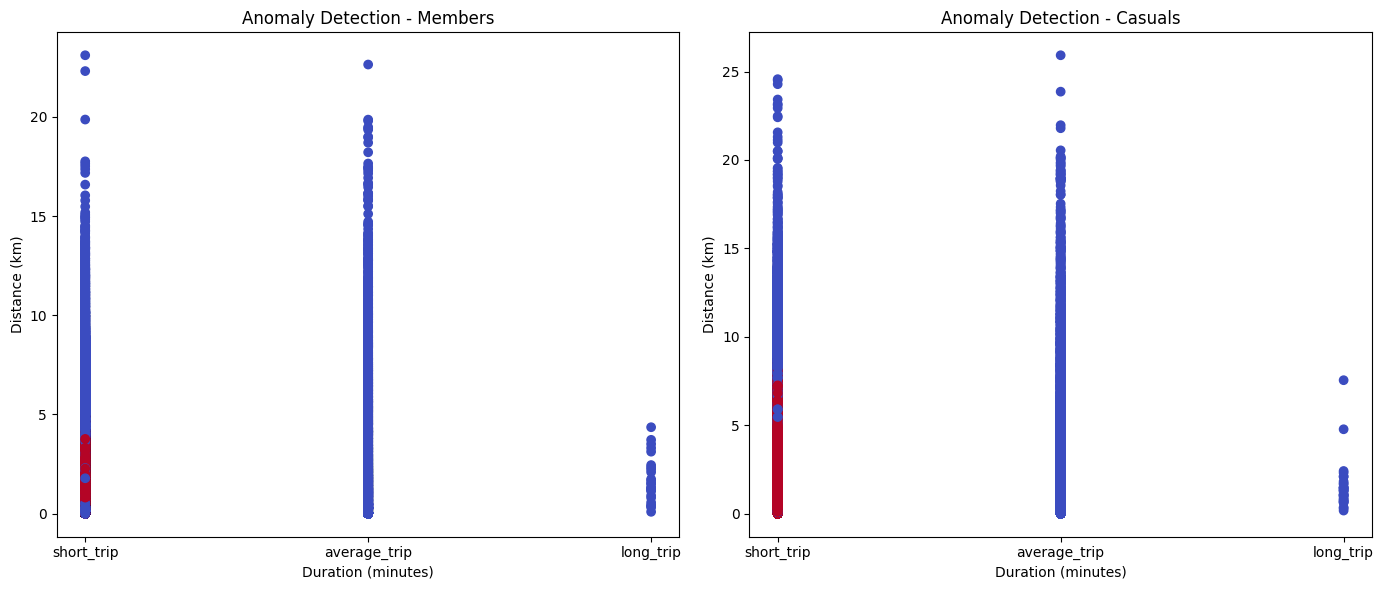

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for members
ax[0].scatter(members['duration'], members['distance'], c=members['anomaly'], cmap='coolwarm')
ax[0].set_title('Anomaly Detection - Members')
ax[0].set_xlabel('Duration (minutes)')
ax[0].set_ylabel('Distance (km)')

# Plot for casuals
ax[1].scatter(casuals['duration'], casuals['distance'], c=casuals['anomaly'], cmap='coolwarm')
ax[1].set_title('Anomaly Detection - Casuals')
ax[1].set_xlabel('Duration (minutes)')
ax[1].set_ylabel('Distance (km)')

# Show the plots
plt.tight_layout()
plt.show()